#### Name - Sachid Deshmukh
#### Date - 07/02/2019
#### Data 612 Assignment-4

##### In this assignment we will use MovieLens dataset. It has been collected by the GroupLens Research Project at the University of Minnesota. It consists of:

 - 100,000 ratings (1-5) from 943 users on 1682 movies.
 - Each user has rated at least 20 movies.
 - Simple demographic info for the users (age, gender, occupation, zip)
 - Genre information of movies

#### In this assigmnment we will build two recommender systems and access their performance
- Recomendation based on global mean and user/movie bias
- Recommendation based on Item-Item collaborative filtering
#### We will use training set to build a recommender system and evaluate it's performance on the test set. We will use RMSE (Root mean square error) as a measure of model efficiency. Model wil low RMSE will win over model with higher RMSE

#### Import necessary libraries

In [728]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.spatial.distance import cosine

#### Read data. For computational efficiency reduce the train and test data size

In [729]:
#Reading ratings file:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings_base = pd.read_csv('D:/MSDS/MSDSQ3Data612/Assignment-4/Data/ua.base', sep='\t', names=r_cols, encoding='latin-1')
ratings_base1 = ratings_base[ratings_base.movie_id.isin([20,33,61,117,155,160,171,189,202,265])]
ratings_base2 = ratings_base[ratings_base.user_id.isin([1])]
train = ratings_base1.append(ratings_base2.iloc[:20,:])

ratings_test = pd.read_csv('D:/MSDS/MSDSQ3Data612/Assignment-4/Data/ua.test', sep='\t', names=r_cols, encoding='latin-1')
test = ratings_test[ratings_test.user_id.isin([1])]
globalmean = np.mean(ratings_base.rating)

#### Model-1 Recommendation based on global mean, user bias and movie bias
#### Calculate global mean, userbias and movie bias

In [730]:
userbias = train.groupby('user_id')['rating'].mean() - globalmean
moviebias = train.groupby('movie_id')['rating'].mean() - globalmean


#### Function to calculate recommendation based on globalmean, userbias and moviebias. We will apply this function on test set to get reccomendation for a given user.

In [731]:
def reccRating(row):
    try:
        ub = pd.to_numeric(userbias[row.user_id])
        mb = pd.to_numeric(moviebias[row.movie_id])
        return globalmean + ub + mb
    except:
        return globalmean

test.loc[:,'recc_rating'] = test.apply(reccRating, axis=1)

#### Model-2 Recommendation based on Item-Item collaborative filtering
#### Build recommendation model

In [732]:
#User Item collaborative Filtering
train.drop('unix_timestamp', axis=1, inplace=True)
training = train.pivot_table(index=['user_id'], columns=['movie_id'])
training.columns = training.columns.droplevel().rename(None)
training.fillna(0, inplace=True)

In [733]:
#Create dataframe to store Item to Item cosine distance
data_ibs = pd.DataFrame(index =training.columns, columns = training.columns)
# Lets fill in those empty spaces with cosine similarities
# Loop through the columns
for i in range(0,len(data_ibs.columns)) :
    # Loop through the columns for each column
    for j in range(0,len(data_ibs.columns)) :
      # Fill in placeholder with cosine similarities
      data_ibs.iloc[i,j] = 1-cosine(training.iloc[:,i],training.iloc[:,j])

In [734]:
# Create a placeholder items for closes neighbours to an item
data_neighbours = pd.DataFrame(index=data_ibs.columns,columns=range(1,11))
data_sim = pd.DataFrame(index=data_ibs.columns,columns=range(1,11))
# Loop through our similarity dataframe and fill in neighbouring item names
for i in range(0,len(data_ibs.columns)):
    data_neighbours.iloc[i,:10] = data_ibs.iloc[0:,i].sort_values(ascending=False)[:10].index
    data_sim.iloc[i,:10] = data_ibs.iloc[0:,i].sort_values(ascending=False)[:10].values

#### Calculate recommendation based on Item-Item collaborative filtering model built above
#### For each user-movie combination in test dataset do following
- Find nearest neighbors for a movie (top 10 neighbors)
- Find cosine distance of those neighbors from the movie being recommended to user
- Calculate the movie rating by taking weighted average of neighbors item rating and cosine distance
- Weighted average formulae - Recc Rating = sum(neighborsrating * neighbors cosine distance)/sum(neighbors cosine distance)

In [735]:
item_recc_rating = []
for x in range(test.shape[0]):
#for x in range(2):
    movie_id = test.iloc[x][1]
    neighbors = data_neighbours[data_neighbours.index==movie_id].values
    sims = data_sim[data_sim.index==movie_id].values
    filterdf = train[train.movie_id.isin(neighbors[0])]
    filtagg = filterdf.groupby('movie_id')['rating'].mean()
    filtagg.head()
    m_rating=[]
    for i in range(len(filtagg.index)):
        m_rating.append(filtagg.iloc[i] * sims[0][i])
        
    m_rating = sum(m_rating)/sum(sims[0])
    item_recc_rating.append(np.max(m_rating))

#### View the test set. Pay attention to recc_rating and Item_recc_rating columns
- Column rating represents actual rating give by user to particular movie
- Column recc_rating represetns recommendation provided by model-1
- Column item_recc_rating represents recommendation provided by model-2

In [736]:
test.loc[:,'item_recc_rating'] = item_recc_rating
test.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,user_id,movie_id,rating,unix_timestamp,recc_rating,item_recc_rating
0,1,20,4,887431883,3.620435,3.523990
1,1,33,4,878542699,3.736847,3.546035
2,1,61,4,878542420,4.133316,3.546456
3,1,117,3,874965739,3.966798,3.554915
4,1,155,2,878542201,3.369923,3.543733


#### Calculate RMSE for both the models

0.819297700815001
0.9023497739293493


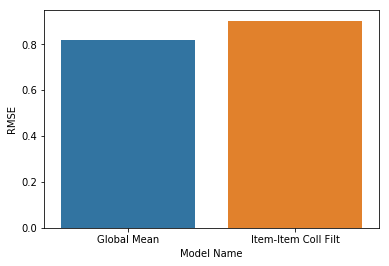

In [737]:

RMSE_1 = math.sqrt(sum(((test.rating - test.recc_rating)**2))/test.shape[0])
print(RMSE_1)

RMSE_2 = math.sqrt(sum(((test.rating - test.item_recc_rating)**2))/test.shape[0])
print(RMSE_2)

model1 = ['Global Mean', 'Item-Item Coll Filt']
model2 = [RMSE_1, RMSE_2]
acc_df = pd.DataFrame(list(zip(model1,model2)), columns = ['Model Name', 'RMSE'])

%matplotlib inline
sns.barplot(acc_df['Model Name'], acc_df['RMSE'])

### Conclusion

#### From the above bar plot we can see that Global mean model have smaller RMSE than Item-Item colaborative filtering. This result is surprising since we expect Item-Item collaborative filtering model superior and more personalized than global mean model. 

#### In Data science world it is not very surprising to get such results. This is a typical case of underfitting or highly biased model. Since we are working on smaller dataset, complex models have tendancy to underfit. Simpler models like global mean works really well when data size is small. It is one of the reccomendations from Data Science community to go for a simpler model if data size is smaller.

#### If we include more and more data to fit our models Item-Item collaborative filtering model will surpass the global mean model since it will improve on overall model fit. 

#### For now we will conclude our experient with the note that we have high bias in out Item-Item collaborative filtering model which we need to address by including more data